In [1]:
%%capture
%cd ".."
%matplotlib widget
%config InlineBackend.print_figure_kwargs={'bbox_inches': None}

import matplotlib
matplotlib.rcParams['figure.dpi'] = 85

# Demo - Classify KRDZ data (1) - Within a single tile

In [2]:
%%capture

from src.shaft import KRDZGear
from src.utils import TrackFixityDB

krdzg = KRDZGear(db_instance=TrackFixityDB())

## 1. Read data of a given tile

In [3]:
from src.utils import get_tile_xy

pcd_date = '201910'
# pcd_date = '202004'

# tile_xy = (350700, 679200)
# tile_xy = (379500, 666900)
# tile_xy = (379500, 667100)
# tile_xy = (379500, 666800)
# tile_xy = (379600, 667100)
# tile_xy = (379700, 667300)
# tile_xy = (379700, 667300)
# tile_xy = (379700, 667600)
# tile_xy = (379700, 667800)
# tile_xy = (379500, 668100)
# tile_xy = (340800, 674300)
# tile_xy = (392000, 659700)
# tile_xy = (391700, 659700)
# tile_xy = (391700, 659700)
# tile_xy = (391700, 659800)
# tile_xy = (391200, 660000)
# tile_xy = (399500, 653600)
# tile_xy = (399500, 653500)
# tile_xy = (399500, 653800)
# tile_xy = (340700, 674200)
# tile_xy = (357000, 678200)
# tile_xy = (390800, 660000)
tile_xy = (399400, 653400)

tile_x, tile_y = get_tile_xy(tile_xy=tile_xy)

# KRDZ data
krdz_xyz = krdzg.load_pcd_krdz(tile_xy=(tile_x, tile_y), pcd_date=pcd_date)

print(list(krdz_xyz.keys()))

['LeftTopOfRail', 'LeftRunningEdge', 'RightTopOfRail', 'RightRunningEdge', 'Centre']


## 2. Test and compare three clustering algorithms

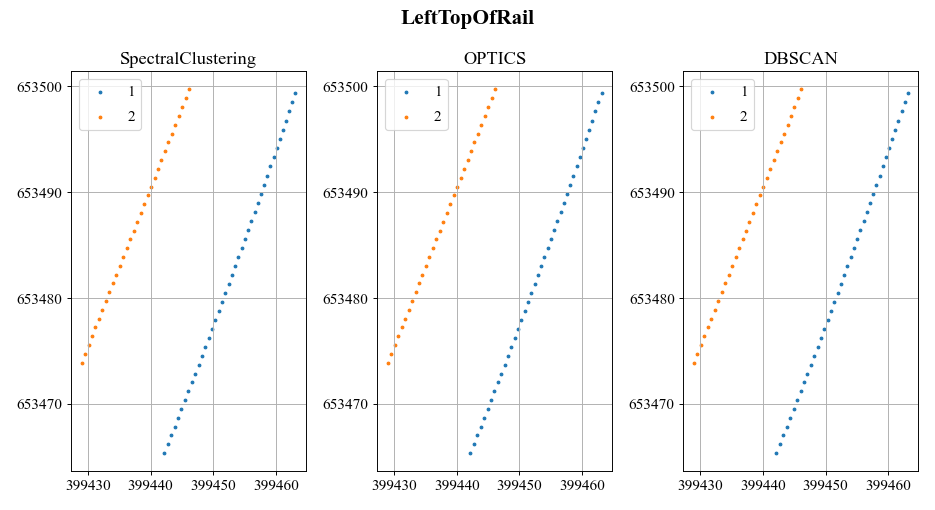

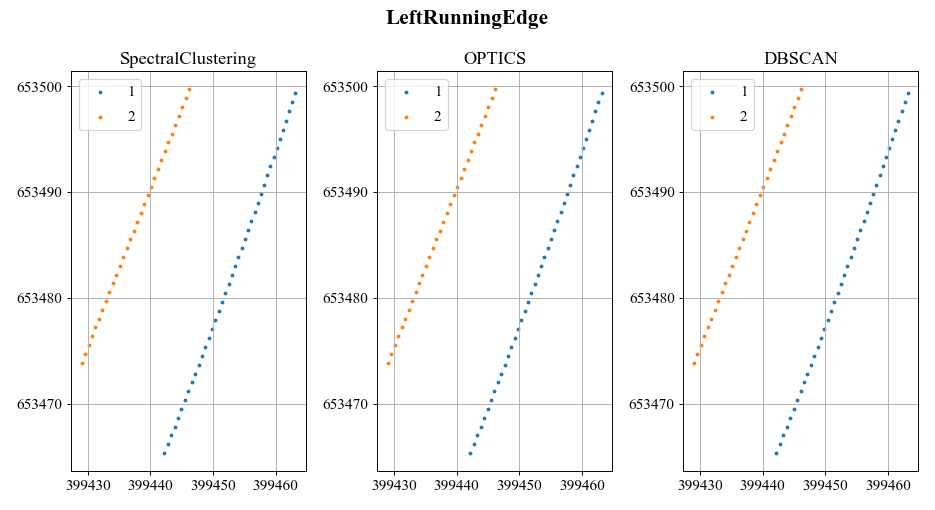

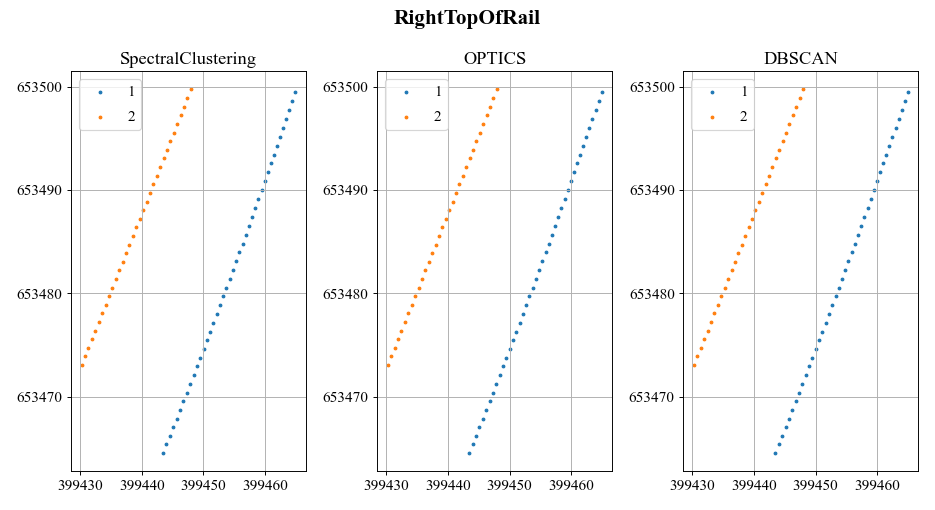

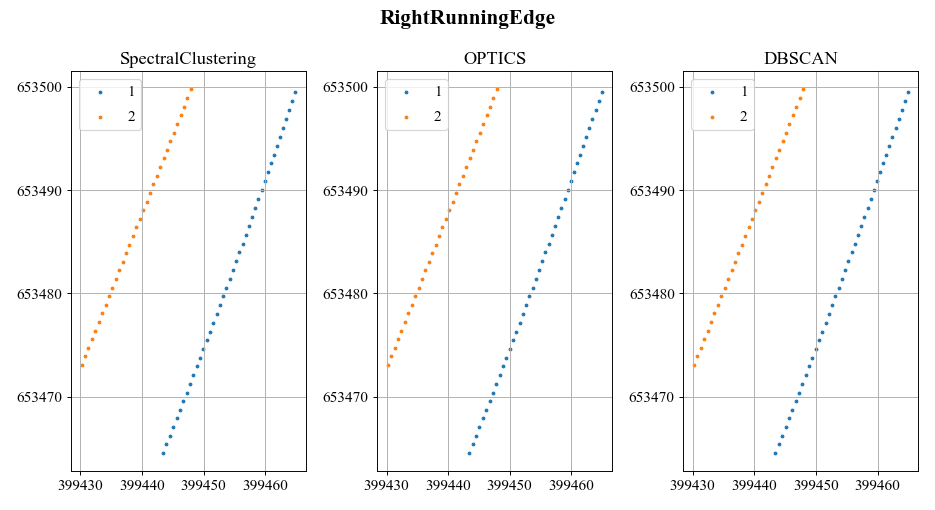

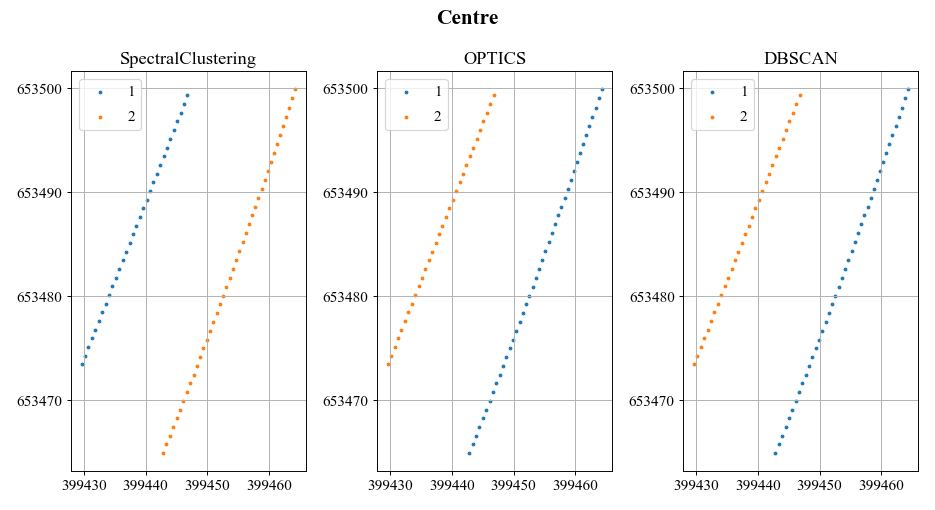

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.ticker
from sklearn.cluster import SpectralClustering, OPTICS, DBSCAN
from src.utils import find_shortest_path


for elem, dat in krdz_xyz.items():
    
    if dat.size > 0:
        
        # Create a clustering model
        clustering_models = {
            'SpectralClustering': SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(dat), 
            'OPTICS': OPTICS(min_samples=2, max_eps=1.05).fit(dat), 
            'DBSCAN': DBSCAN(eps=2, min_samples=2, algorithm='brute').fit(dat)
        }

        fig = plt.figure(figsize=(11, 6))  # , constrained_layout=True
        mgs = gs.GridSpec(1, len(clustering_models), figure=fig)
        
        for i, (name, model) in enumerate(clustering_models.items()):
            ax = fig.add_subplot(mgs[:, i])
            ax.ticklabel_format(useOffset=False)
            # ax.set_aspect('equal', adjustable='box')

            labels, idx = np.unique(model.labels_, return_index=True)
            xyz1 = find_shortest_path(dat[model.labels_ == labels[0]])
            xyz2 = find_shortest_path(dat[model.labels_ != labels[0]])

            ax.scatter(xyz1[:, 0], xyz1[:, 1], s=5, label=1)
            ax.scatter(xyz2[:, 0], xyz2[:, 1], s=5, label=2)
            
            ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
            ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))

            ax.grid()
            
            ax.set_title(name)

            ax.legend(loc='best')
        
        fig.suptitle(elem, fontsize=18, fontweight='bold')
        
        fig.tight_layout()

## 3. Apply the best clustering algorithm

In [5]:
clustered_krdz_data = krdzg.classify_krdz(tile_xy=tile_xy, pcd_date='201910', n_jobs=-1, update=True, verbose=True)

Updating "Tile_X+0000399400_Y+0000653400.pickle" at "data\PCD\ECM8\KRDZ\201910\" ... Done.


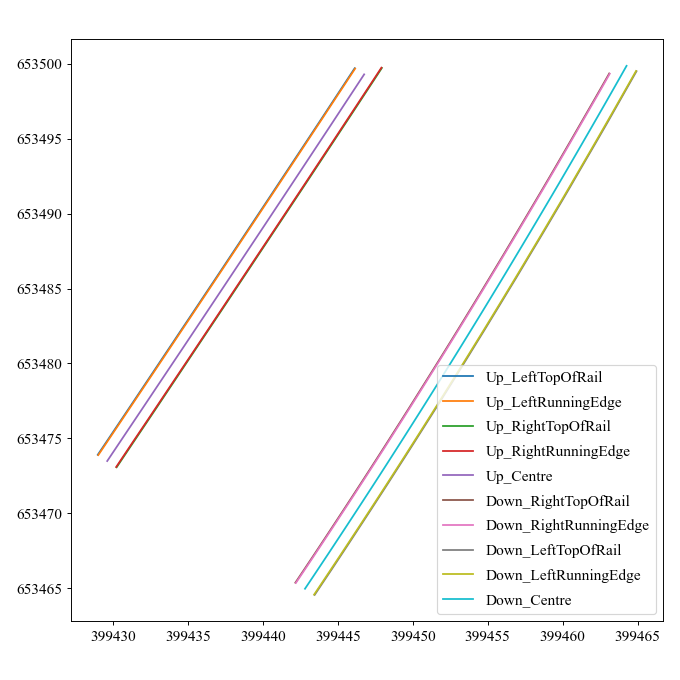

In [6]:
fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(aspect='equal', adjustable='box')
ax1.ticklabel_format(useOffset=False)

# ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
# ax1.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))

for elem, dat in clustered_krdz_data.items():
    dat = np.unique(np.array(dat.coords), axis=0)

    if len(dat) >= 1:
        if len(dat) == 1:
            ax1.scatter(dat[:, 0], dat[:, 1], label=elem)
        else:
            dat = find_shortest_path(dat)
            ax1.plot(dat[:, 0], dat[:, 1], label=elem)

ax1.legend(loc='best')
fig1.tight_layout()

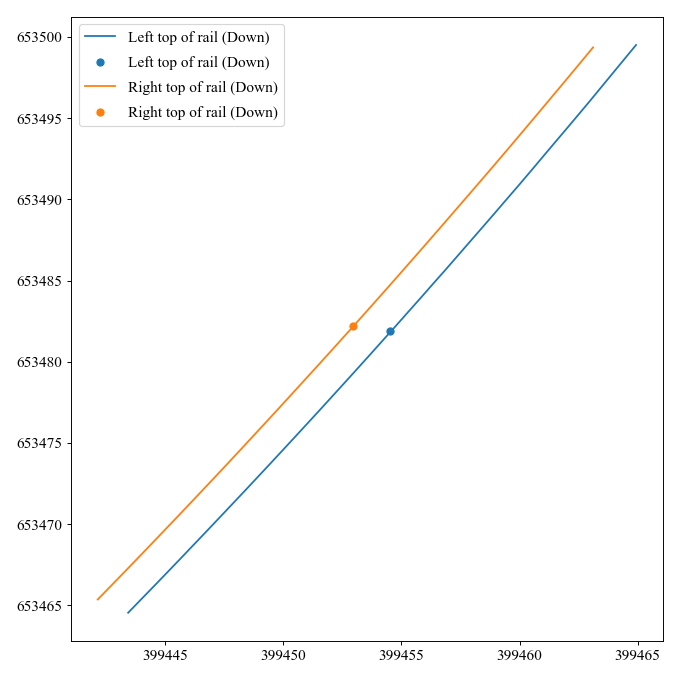

In [7]:
dlt = clustered_krdz_data['Down_LeftTopOfRail']
drt = clustered_krdz_data['Down_RightTopOfRail']

fig2 = plt.figure(figsize=(8, 8))
ax2 = fig2.add_subplot()
ax2.ticklabel_format(useOffset=False)

# ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(100))
# ax2.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(100))

dlt_ = np.array(dlt.coords)
drt_ = np.array(drt.coords)

if len(dlt_) > 1:
    ax2.plot(dlt_[:, 0], dlt_[:, 1], label='Left top of rail (Down)')
    ax2.scatter(dlt.interpolate(0.5, normalized=True).x, dlt.centroid.y, label='Left top of rail (Down)')
if len(drt_) > 1:
    ax2.plot(drt_[:, 0], drt_[:, 1], label='Right top of rail (Down)')
    ax2.scatter(drt.interpolate(0.5, normalized=True).x, drt.centroid.y, label='Right top of rail (Down)')

ax2.legend()
fig2.tight_layout()